In [3]:
import os
from matplotlib import pyplot as plt

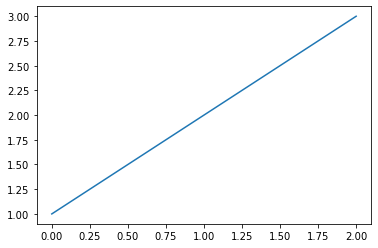

In [4]:
plt.plot([1,2,3])

In [1]:
cd '/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks'

/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks


In [2]:
pwd

'/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks'

In [3]:
%matplotlib inline

In [4]:
from datetime import datetime;now = datetime.now;t00 = now()
print(t00)

2021-05-28 09:33:20.476784


In [5]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
#%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [7]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-d4562c18-3d01-4110-d707-48b82ba5de9d)
GPU 1: Tesla V100-SXM2-16GB (UUID: GPU-9c44e4aa-2342-c342-437b-2f435f4aa581)
GPU 2: Tesla V100-SXM2-16GB (UUID: GPU-5da48514-1b80-9761-08a6-1818f6a51f67)
GPU 3: Tesla V100-SXM2-16GB (UUID: GPU-81adc8d7-7c25-3e6b-e732-d72679baf578)


In [8]:
from importlib import reload

import helper_funcs;reload(helper_funcs);from helper_funcs import *

import make_models;reload(make_models);from make_models import *

# Make tqdm work for colab
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [9]:
#%tensorflow_version 2.x
import tensorflow as tf
import timeit,pickle

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.197818866930902
GPU (s):
0.03128630295395851
GPU speedup over CPU: 6x


In [10]:
%matplotlib inline

import os
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from tqdm import tqdm

import pandas as pd
from sklearn.metrics import silhouette_score

#from mri_utils import get_MRI_CVAE_3D,get_MRI_CCVAE_3D

print(now()-t00)

0:00:29.519203


In [11]:
cd ../

/mmfs1/data/aglinska/BC-MRI-AE


In [13]:
arr = np.load('./Data/ABIDE-Anat-64iso.npz')
ABIDE_data = arr['data']
ABIDE_subs = arr['subs']
nsubs = ABIDE_data.shape[0]
[arr.shape for arr in [ABIDE_subs,ABIDE_data]]

[(1022,), (1022, 64, 64, 64)]

In [14]:
aa = np.array([ABIDE_data[s,:,:,:].sum() for s in range(ABIDE_data.shape[0])])<5000
ABIDE_data = ABIDE_data[~aa,:,:,:]
ABIDE_subs = ABIDE_subs[~aa]
[arr.shape for arr in [ABIDE_subs,ABIDE_data]]

[(982,), (982, 64, 64, 64)]

In [16]:
# ABIDE_data = np.load('/mmfs1/data/aglinska/ABIDErData.npy')

In [17]:
# print(ABIDE_data.shape)

In [18]:
# #ABIDE_data = np.load('/mmfs1/data/aglinska/ABIDE_Data_rb.npy.npz')['data']
# ABIDE_data = np.load('/mmfs1/data/aglinska/ABIDE_data_rb.npz')['data']#.astype(np.float32)
# print(ABIDE_data.shape)

In [19]:
def norm_array(mat):
    mat[mat<0] = 0
    return (mat-mat.flatten().min()) / (mat.flatten().max()-mat.flatten().min())

In [20]:
ABIDE_data = np.array([norm_array(ABIDE_data[s,:,:,:]) for s in tqdm(range(ABIDE_data.shape[0]))])

100%|██████████| 982/982 [00:00<00:00, 991.15it/s] 


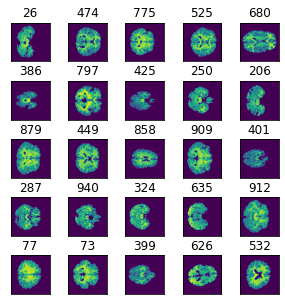

In [21]:
f, axs = plt.subplots(5,5,figsize=(5,5));
c = -1
for i in range(5):
    for j in range(5):
        c = np.random.randint(low=0,high=ABIDE_data.shape[0])
        axs[i,j].imshow(ABIDE_data[c,:,:,32])
        axs[i,j].set_xticks([]);axs[i,j].set_yticks([]);axs[i,j].set_title(c)
plt.subplots_adjust(wspace=.15,hspace=.5)

In [22]:
#np.nonzero(bad_idx)

In [23]:
cc = np.corrcoef(ABIDE_data.reshape(ABIDE_data.shape[0],-1)).mean(axis=0)
bad_idx = cc<.8

In [24]:
df = pd.read_csv('./Data/ABIDE_legend_S982.csv',header=0)
#df = df.iloc[np.array([df['BIDS_ID'].values[s] in ABIDE_subs for s in range(len(df))])]
df.reset_index(inplace=True)


#df = df.drop(df[bad_idx].index)
#ABIDE_data = ABIDE_data[~bad_idx,:,:,:]
#ABIDE_subs = df['BIDS_ID'].values

df.head(5)

,level_0,Unnamed: 0,index,BIDS_ID,Anonymized ID,Subject Type,Visit,Days since enrollment,SubID,DxGroup,...,WISC4 Sym Scaled,Age at MPRAGE,Current Med Status,Medication Name,Medication Name.1,Off stimulants at EPI scan?,ScanSite,ScannerType,ScannerID,ScanSiteID
0,0,431,544,sub-435,A00032146,PATIENT,session_1,29,51026,1,...,NaN,NaN,1.0,NaN,Amphetamine and Dextroamphetamine,1.0,nyu,allegra,1,4
1,1,540,653,sub-544,A00032096,PATIENT,session_1,29,50987,1,...,NaN,NaN,0.0,NaN,NaN,NaN,nyu,allegra,1,4
2,2,595,708,sub-599,A00032111,PATIENT,session_1,29,51003,1,...,NaN,NaN,0.0,NaN,NaN,NaN,nyu,allegra,1,4
3,3,670,783,sub-674,A00033338,CONTROL,session_1,8,50821,2,...,9.0,NaN,0.0,NaN,NaN,NaN,kki,achieva,0,1
4,4,489,602,sub-493,A00032104,PATIENT,session_1,29,50995,1,...,NaN,NaN,0.0,NaN,NaN,NaN,nyu,allegra,1,4


In [25]:
print(ABIDE_data.shape)
print(df.shape)

(982, 64, 64, 64)
(982, 91)


In [26]:
#ABIDE_data = np.load('/mmfs1/data/aglinska/3d_grassy_mnist/fake_abide.npy')
TD_subs = ABIDE_data[np.array(df['Subject Type']=='CONTROL'),:,:,:]
DX_subs = ABIDE_data[np.array(df['Subject Type']=='PATIENT'),:,:,:]

print(TD_subs.shape)
print(DX_subs.shape)

(500, 64, 64, 64)
(456, 64, 64, 64)


In [27]:
dxArr = np.ones(len(df))
dxArr[np.array(df['Subject Type']=='PATIENT')]=2

In [28]:
# Get Scanner Types and Scanning Site
#df2 = pd.read_csv('/Users/aidasaglinskas/Desktop/BC-MRI-AE/CSVs/ABIDE_BIDS_PATHS.csv',index_col=0)
df = df.sort_values(by='BIDS_ID')
df2 = pd.read_csv('/mmfs1/data/aglinska/BC-MRI-AE/CSVs/ABIDE_BIDS_PATHS.csv',index_col=0)
df2.index=np.arange(len(df2))
df2 = df2.iloc[np.array([df2['subID'].values[s] in df['BIDS_ID'].values for s in np.arange(len(df2))])]
df2.index=np.arange(len(df2))
df2 = df2.sort_values('subID')
df2.index=np.arange(len(df2))
print(f'{len(df2)}/{len(df)}')
n = len(df2)
df2.head()

assert len(df2)==len(df), 'different lenghts of CSVs'
assert all(np.array([df2['subID'].values[s]==df['BIDS_ID'].values[s] for s in np.arange(len(df))])),'mismatch between CSV orders'

982/982


In [29]:
df['ScanSite'] = [val.split('/')[6] for val in df2['sub_path'].values]
df['ScannerType'] = [val.split('/')[8] for val in df2['sub_path'].values]

In [30]:
df['ScannerID'] = str_to_ordinal(df['ScannerType'].values)
df['ScanSiteID'] = str_to_ordinal(df['ScanSite'].values)

patients = df['DxGroup'].values==1
controls = df['DxGroup'].values==2

In [31]:
print(df.shape)
print(ABIDE_data.shape)

(982, 91)
(982, 64, 64, 64)


In [35]:
dataFnOut = '/mmfs1/data/aglinska/BC-MRI-AE/Data/ABIDE-Anat-64iso-S982_v2.npz'
dfFnOut = '/mmfs1/data/aglinska/BC-MRI-AE/Data/ABIDE_legend.csv'
np.savez_compressed(dataFnOut,data=ABIDE_data,subs=ABIDE_subs)
#df.to_csv(dfFnOut)

In [36]:
#np.savez_compressed('/mmfs1/data/aglinska/BC-MRI-AE/Data/ABIDE-subs-982.npz',subs=ABIDE_subs)


In [31]:
train_vae = True

In [32]:
if train_vae:
    from scipy.spatial.distance import pdist
    from scipy.spatial.distance import squareform

def plot_recon_vae():
    plt.figure(figsize=(5,5));
    plt.subplot(2,2,1)
    plt.imshow(DX_batch[0,:,:,40]);plt.xticks([]);plt.yticks([]);plt.title('input');
    plt.subplot(2,2,2)
    plt.imshow(cvae.predict([DX_batch,TD_batch])[0][0,:,:,40,0]);plt.xticks([]);plt.yticks([]);plt.title('reconstruction');

    plt.subplot(2,2,3)
    plt.imshow(TD_batch[0,32,:,:]);plt.xticks([]);plt.yticks([]);
    plt.subplot(2,2,4)
    plt.imshow(cvae.predict([DX_batch,TD_batch])[1][0,32,:,:,0]);plt.xticks([]);plt.yticks([]);

In [33]:
import pickle
import make_models;reload(make_models);from make_models import *

if train_vae:
    latent_dim=256;batch_size=64;disentangle=True;gamma=100
    
    encoder, decoder, vae = get_MRI_VAE_3D(input_shape=(64, 64, 64, 1), latent_dim=latent_dim, batch_size=batch_size, disentangle=disentangle, gamma=gamma)
    loss = list()
    print('ready')
    #fn = '/mmfs1/data/aglinska/tf_outputs/VAE/Jan4th'
    #fn = '/mmfs1/data/aglinska/tf_outputs/VAE/Feb_26_32DB64G100_DisTrue'
    #fn = '/mmfs1/data/aglinska/tf_outputs/VAE/APR_4th_D32DTrue_G100_adam'
    #fn = '/mmfs1/data/aglinska/tf_outputs/VAE/April8_fakeAbide_VAE_l64'
    fn = '/mmfs1/data/aglinska/tf_outputs/VAE/may_new'
    
#     if  os.path.exists(fn+'_loss.pickle'):
#         print('loading weights')
#         vae.load_weights(fn)
#         loss = pickle.load(open(fn+'_loss.pickle','rb'))
#     else:
#         print('no weights found - initializing new')
        
    print(fn)
    
    im1 = ABIDE_data[0:5,:,:,:][0,:,:,32];
    im = vae.predict(ABIDE_data[0:5,:,:,:])[0,:,:,32,0];
    #plot_trainProgress(loss,im,im1);

ready
loading weights
/mmfs1/data/aglinska/tf_outputs/VAE/may_new


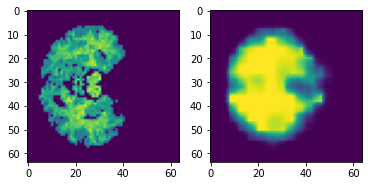

In [34]:
plt.subplot(1,2,1)
plt.imshow(im1)
plt.subplot(1,2,2)
plt.imshow(im)

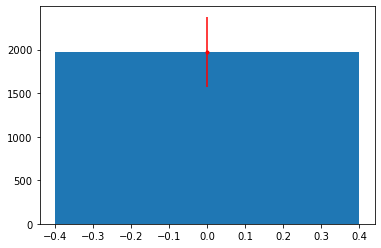

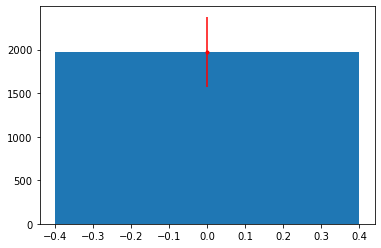

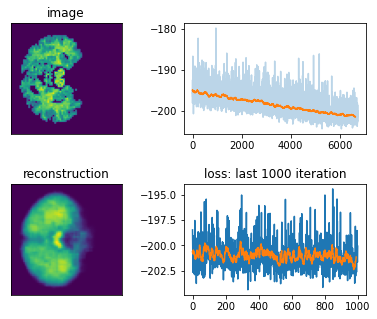

100%|██████████| 9999/9999 [1:17:10<00:00,  2.16it/s]


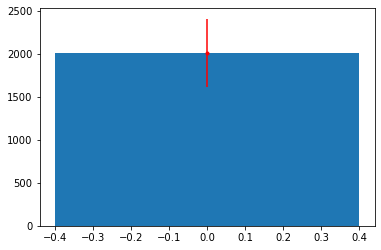

In [35]:
if train_vae:
    batch_size = 64
    for i in tqdm(range(1,10000)):    
        history = vae.train_on_batch(ABIDE_data[np.random.randint(low=0,high=ABIDE_data.shape[0],size=batch_size),:,:,:]);
        assert not any(np.isnan(loss)), 'nans in the loss'
        
        loss.append(history);
        
        if np.mod(i,100)==0:
            im1 = ABIDE_data[0:5,:,:,:][0,:,:,32];
            im = vae.predict(ABIDE_data[0:5,:,:,:])[0,:,:,32,0];
            plot_trainProgress(loss,im,im1);
            
            
        if np.mod(i,100)==0: #Check accuracy
            #display.clear_output(wait=True);
            #display.display(plt.gcf());
            matIn = ABIDE_data[0:100,:,:,:]
            vae_out = decoder.predict(encoder(matIn)[2])[:,:,:,:,0]
            vae_resid = (matIn-vae_out)**2
            vae_acc = np.array([vae_resid[i,:,:,:].sum() for i in range(matIn.shape[0])])
            acc = np.mean(vae_acc)

            plt.bar(0,np.mean(vae_acc))
            plt.errorbar(0,np.mean(vae_acc),np.std(vae_acc),fmt='r.')
            
            if acc < 1500:
                break

        if np.mod(i,100)==0:
            pickle.dump(loss,open(fn+'_loss.pickle','wb'))
            vae.save_weights(fn)

In [34]:
train_cvae = True

In [35]:
items = get_weights(fdir=None)

00 | 16dim_noDis_evBatch
01 | Feb03_1459_D16B1G100_DTrue
02 | Feb04_0524_D16B1G100_DTrue
03 | Feb04_0524_D16B1G100_DTrue_continued
04 | Feb05_0908_D16B1G100_DTrue
05 | Feb23_1049_D16B1G1_DTrue
06 | Feb23_1400_D2B1G100_DTrue
07 | Feb23_1551_D16B1G100_DTrue
08 | Feb26_1330_CVAE_D16B1G1_adam
09 | Feb26_1330_forPaperFakeAbide
10 | Feb26_1330_playforClustering
11 | Feb_3d_16D_Dis_fixed
12 | Jan12_disentagled_l16
13 | Jan24_d16_dis_flipped_b5g20
14 | Jan24_d16_dis_flipped_b5g20_earlyStop
15 | Jan4th
16 | Mar18_1312_CVAE_D16B1G1_adam_rData
17 | Mar18_1312_CVAE_D16B1G1_adam_rData2
18 | Mar18_2009_CVAE_D16B1G100_adam4real_rData
19 | Mar18_2009_CVAE_D16B1G100_adam4real_rData2
20 | Mar18_2009_CVAE_D16B1G100_adam_rData2
21 | Mar18_2009_CVAE_D16B1G100_adam_rData3
22 | Mar18_2009_CVAE_D2B1G1_rmsprop
23 | Mar20_2125_CVAE_D16B1G100_adamBspline_r
24 | Mar20_2125_CVAE_D16B1G100_adamBspline_r2
25 | Mar20_2125_CVAE_D16B1G1_ADAM_Bspline_l
26 | Mar20_2125_CVAE_D16B1G1_ADAM_Bspline_r2_new
27 | Mar20_2125_CVA

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

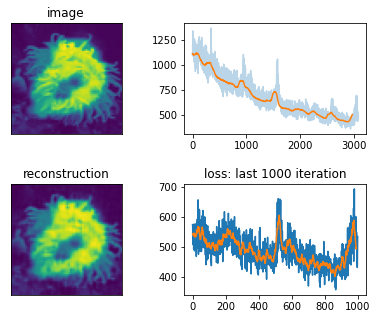

/mmfs1/data/aglinska/tf_outputs/CVAE/Feb26_1330_forPaperFakeAbide


In [42]:
import helper_funcs;reload(helper_funcs);from helper_funcs import *
import make_models;reload(make_models);from make_models import *

if train_cvae:
    latent_dim = 16
    batch_size = 32
    beta = 5;gamma = 100
    disentangle = True
    cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CCVAE_3D(latent_dim=latent_dim,beta=beta, disentangle=disentangle, gamma=gamma, bias=True, batch_size = batch_size)
    loss = list()    
    
    fdir = '/mmfs1/data/aglinska/tf_outputs/CVAE/'
    #fn = f'{now().strftime("%b%d_%H%M")}_D{latent_dim}B{beta}G{gamma}_D{disentangle}'
    #fn = 'Feb04_0524_D16B1G100_DTrue'
    #fn = 'Feb04_0524_D16B1G100_DTrue'
    
    #fn = os.path.join(fdir,items[2])
    
    #fn = os.path.join(fdir,'Mar20_2125_CVAE_D16B1G1_ADAM_Bspline_l')
    
    fn = os.path.join(fdir,'Feb26_1330_forPaperFakeAbide')
    fn = os.path.join(fdir,'Feb26_1330_forPaperFakeAbide')
    
    if os.path.exists(fn+'_loss.pickle'):
        loss = pickle.load(open(fn+'_loss.pickle','rb'))
        cvae.load_weights(fn)
        print('weights loaded')
    else:
        print('new model')
        

# Initial Check
import helper_funcs;reload(helper_funcs);from helper_funcs import *
DX_batch = DX_subs[np.random.randint(low=0,high=DX_subs.shape[0],size=batch_size),:,:,:];
TD_batch = TD_subs[np.random.randint(low=0,high=TD_subs.shape[0],size=batch_size),:,:,:];

if len(loss)==0:
    loss.append(np.nan)
    im,im1,ss = cvae_query(ABIDE_data,s_encoder,z_encoder,cvae_decoder);
    plot_trainProgress(loss,im,im1);
    loss = list()
else:
    im,im1,ss = cvae_query(ABIDE_data,s_encoder,z_encoder,cvae_decoder);
    plot_trainProgress(loss,im,im1);

    
dmats = list()
print(fn)

In [105]:
def dim_reduce(z,method='UMAP'):
    
    if method=='UMAP':
        reducer = umap.UMAP()
        #reducer = ParametricUMAP()
    else:
        reducer = PCA(n_components=2)
        
    tiny = reducer.fit_transform(z)
    
    return tiny,reducer

In [125]:
w = 2
encs = [z_encoder.predict, s_encoder.predict]
data = ABIDE_data[patients,:,:,:]
bg_embed = np.array(encs[0](data)[w])
sl_embed = np.array(encs[1](data)[w])
method = 'UMAP'
bg_space,bg_reducer = dim_reduce(bg_embed,method=method)
sl_space,sl_reducer = dim_reduce(sl_embed,method=method)

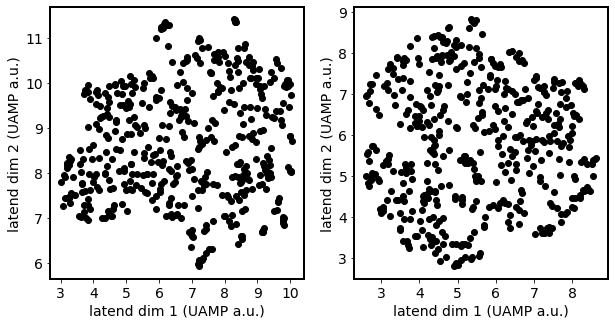

In [257]:
plt.figure(figsize=(10,5))
ax = plt.subplot(1,2,1)
plt.scatter(bg_space[:,0],bg_space[:,1],c='k')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('latend dim 1 (UAMP a.u.)',fontsize=14)
plt.ylabel('latend dim 2 (UAMP a.u.)',fontsize=14)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    
    
ax = plt.subplot(1,2,2)
plt.scatter(sl_space[:,0],sl_space[:,1],c='k')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('latend dim 1 (UAMP a.u.)',fontsize=14)
plt.ylabel('latend dim 2 (UAMP a.u.)',fontsize=14)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    
plt.savefig(ofdir+'mnist_umap.pdf',dpi=300)

In [127]:
# bg_space,sl_space = get_spaces(ABIDE_data, z_encoder, s_encoder, w=2)
# cscatter([bg_space,sl_space],c=df['DxGroup'].values)

In [128]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [129]:
#model = KMeans(n_clusters=3).fit(sl_space)
model = GaussianMixture(n_components=3).fit(sl_space)

In [130]:
#vec = np.hstack((np.zeros((3,16)),sl_reducer.inverse_transform(model.cluster_centers_)))
vec = np.hstack((np.zeros((3,16)),sl_reducer.inverse_transform(model.means_)))
out = cvae_decoder.predict(vec)

In [142]:
arr = np.array([cvae_decoder.predict(vec) for _ in range(50)])
out = arr.mean(axis=0)

In [148]:
from scipy.stats import multivariate_normal as mvnorm

In [186]:
samples = 15
arrs = list()
for i in range(3):
    vec = np.hstack((np.zeros((samples,16)),sl_reducer.inverse_transform(mvnorm(mean=model.means_[i,:], cov=model.covariances_[i,:,:]).rvs(samples))   )      )
    arr = cvae_decoder.predict(vec)
    arrs.append(arr)

In [194]:
#np.save(file='grassyMnistPrototypes', arr=arrs)

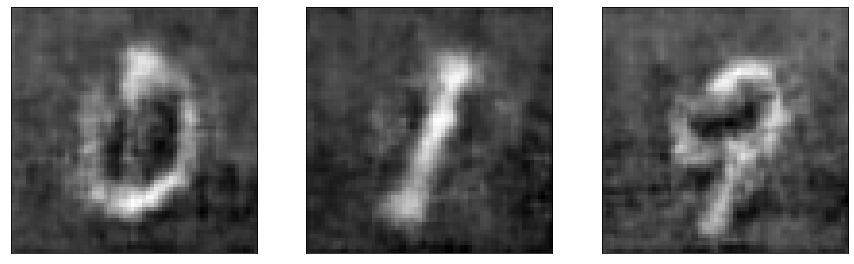

In [294]:
plt.figure(figsize=(15,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(arrs[i].mean(axis=0)[:,:,32,0],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    
#plt.savefig(ofdir+'cluster_centers.pdf',dpi=300)

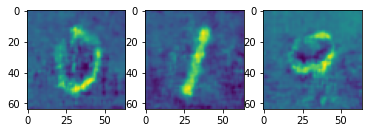

In [291]:
plt.subplot(1,3,1)
plt.imshow(out[0,:,:,32,0])

plt.subplot(1,3,2)
plt.imshow(out[1,:,:,32,0])

plt.subplot(1,3,3)
plt.imshow(out[2,:,:,32,0])

470


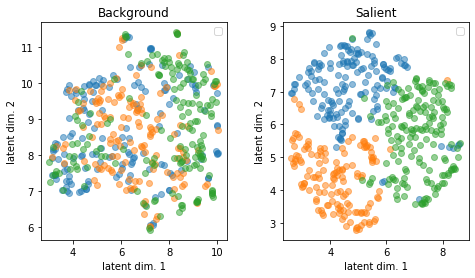

In [270]:
cscatter([bg_space,sl_space],c=cid,legend=[])
plt.savefig(ofdir+'clsuters_color.pdf',dpi=300)

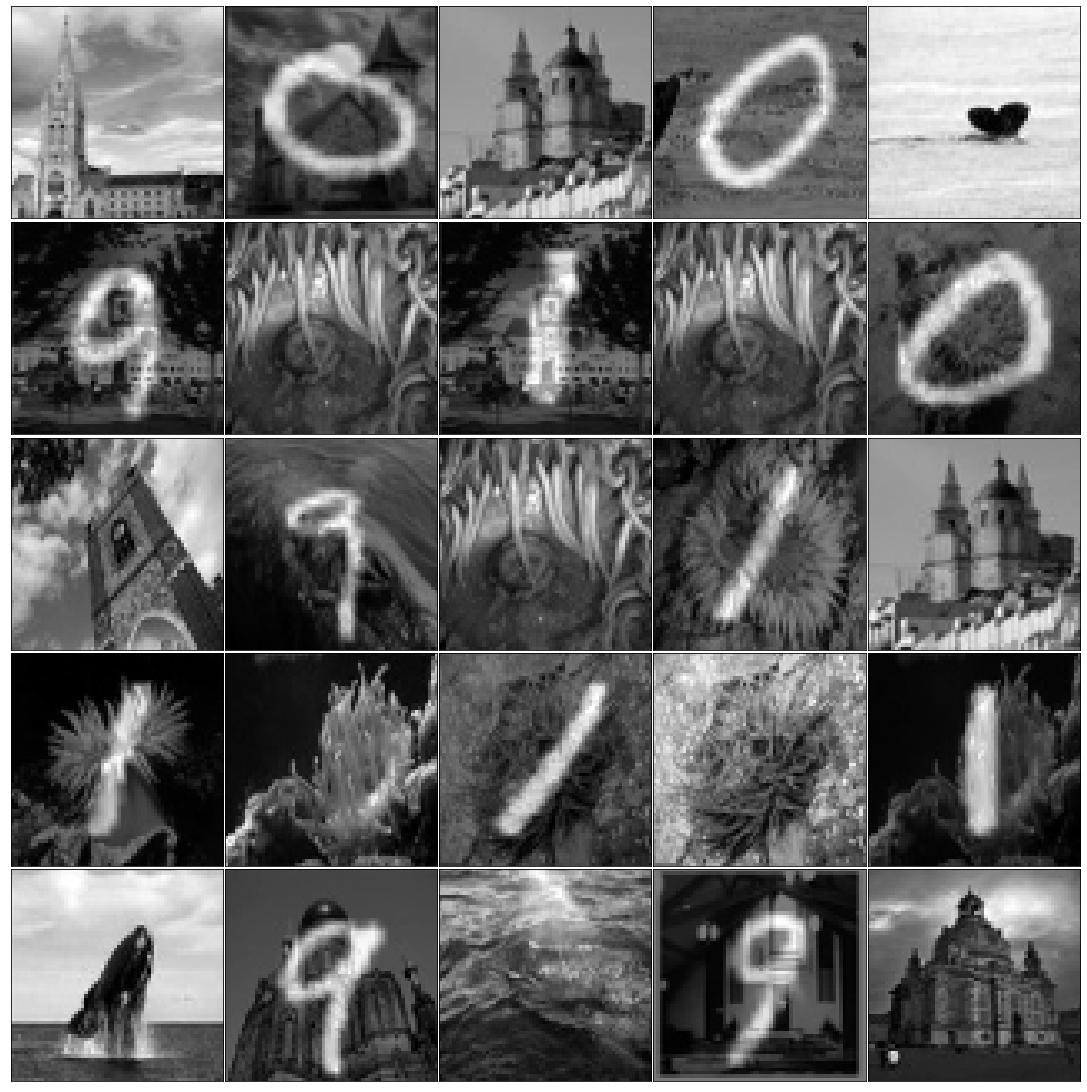

In [298]:
fig, axs = plt.subplots(5,5,figsize=(15,15))
cc = -1

arr = ABIDE_data[np.random.randint(low=0,high=900,size=25),:,:,:]
arr_td = ABIDE_data[controls,:,:,:][np.random.randint(low=0,high=400,size=25),:,:,:]
arr_asd = ABIDE_data[patients,:,:,:][np.random.randint(low=0,high=400,size=25),:,:,:]


for i in range(5):
    for j in range(5):
        cc += 1
        plt.axes(axs[i][j])
        
        
        plt.imshow(arr[cc,:,:,32],cmap='gray')
        
        if np.mod(cc,2)==0:
            plt.imshow(arr_td[cc,:,:,32],cmap='gray')
        else:
            plt.imshow(arr_asd[cc,:,:,32],cmap='gray')
                    
        plt.xticks([])
        plt.yticks([])


plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.subplots_adjust(
left=0.01,
bottom=None,
right=None,
top=None,
wspace=0.01,
hspace=0.01)

plt.savefig(ofdir+'pic_grid.pdf',dpi=300)

In [229]:
import matplotlib.gridspec as gridspec
def plot_sweep(ABIDE_data,z_encoder,s_encoder,cvae_decoder,wspace='z',l=5,w=2,cmap='gray'):

    z = z_encoder.predict(ABIDE_data)
    s = s_encoder.predict(ABIDE_data)

    z_lin = np.linspace(z[2].min(axis=0),z[2].max(axis=0),l)
    s_lin = np.linspace(s[2].min(axis=0),s[2].max(axis=0),l)
    
    nrows = l;ncols = l;c = 0
    
    plt.figure(figsize=(5,5))
    gs1 = gridspec.GridSpec(4, 4)
    gs1.update(wspace=10, hspace=10) 
    
    for i in range(l):
        for j in range(l):
            c+=1
            plt.subplot(nrows,ncols,c)
            vec_z = z_lin[i,:]
            vec_s = s_lin[i,:]
            vec_0 = np.zeros(vec_s.shape)

            if wspace=='z':
                vec3 = np.hstack((vec_z,vec_0))
            elif wspace=='s':
                vec3 = np.hstack((vec_0,vec_s))
            else:
                #vec3 = np.hstack((vec_z,vec_s))
                vec3 = np.hstack((vec_z,vec_s))

            plt.imshow(cvae_decoder.predict(np.vstack((vec3,vec3)))[0,:,:,32,0],cmap=cmap)
            plt.xticks([]);plt.yticks([]);
            
            
    plt.tight_layout(pad=0, w_pad=0, h_pad=0)
    plt.subplots_adjust(
    left=0.01,
    bottom=None,
    right=None,
    top=None,
    wspace=0.01,
    hspace=0.01)


In [237]:
ofdir = '/mmfs1/data/aglinska/BC-MRI-AE/Results/figures/grassymnist/'

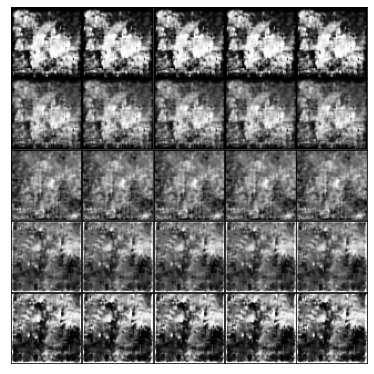

In [238]:
plot_sweep(ABIDE_data, z_encoder, s_encoder,cvae_decoder, wspace='z', l=5)
plt.savefig(ofdir+'bg_sweep.pdf',dpi=300)

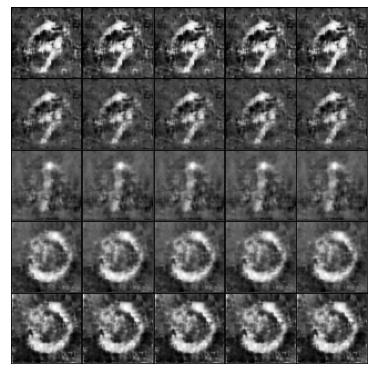

In [239]:
plot_sweep(ABIDE_data, z_encoder, s_encoder,cvae_decoder, wspace='s',l=5)
plt.savefig(ofdir+'sl_sweep.pdf',dpi=300)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

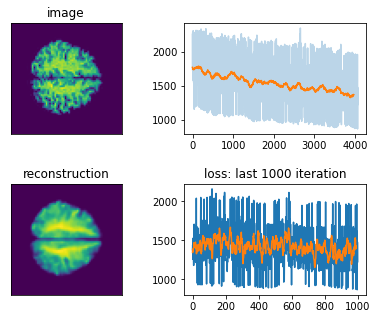

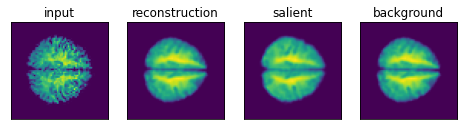

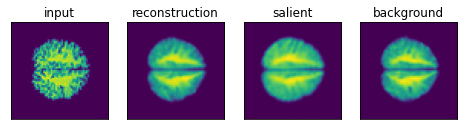

943


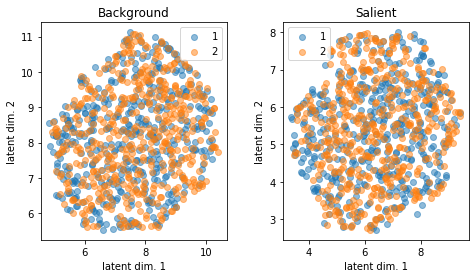

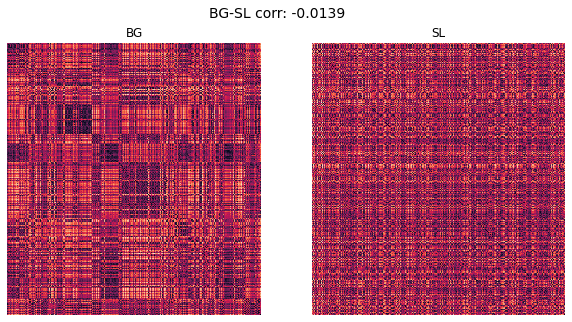

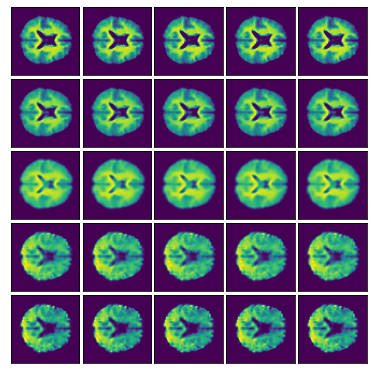

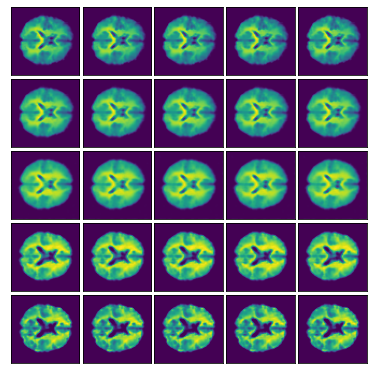

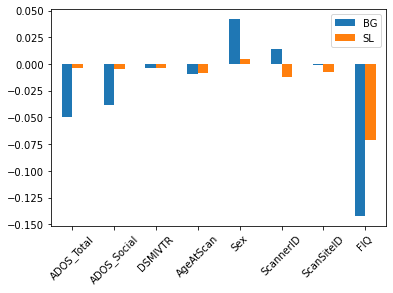

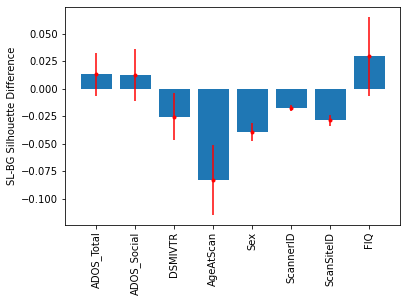

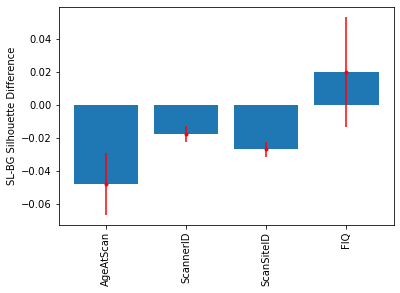

  1%|          | 6172/999999 [2:09:42<195:41:03,  1.41it/s] 

In [ ]:
import helper_funcs;reload(helper_funcs);from helper_funcs import *

for i in tqdm(range(1,int(1e6))):
    
    asd_idx,td_idx = get_batch_idx(df,batch_size = batch_size)
    DX_batch = np.take(ABIDE_data, indices=asd_idx, axis=0)
    TD_batch = np.take(ABIDE_data, indices=td_idx, axis=0)
    
#     DX_batch = DX_subs[np.random.randint(low=0,high=DX_subs.shape[0],size=batch_size),:,:,:];
#     TD_batch = TD_subs[np.random.randint(low=0,high=TD_subs.shape[0],size=batch_size),:,:,:];
    #print(TD_batch.shape)
    hist = cvae.train_on_batch([DX_batch,TD_batch]); # Proper 
    #hist = cvae.train_on_batch([TD_batch,DX_batch]); # Flipped
    
    assert not np.isnan(hist),'loss is NaN - you f**cked up'
    
    im,im1,ss = cvae_query(ABIDE_data,s_encoder,z_encoder,cvae_decoder);
    
    loss.append(hist);
    
    if loss[-1] < 500:
        break
    
    if np.mod(i,100)==0:
        
        plot_trainProgress(loss,im,im1);
        pickle.dump(loss,open(fn+'_loss.pickle','wb'))
        plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=0)
        plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=1)
        bg_space,sl_space = get_spaces(ABIDE_data, z_encoder, s_encoder, w=2)
        cscatter([bg_space,sl_space],c=df['DxGroup'].values)
        
        fig,ax = plt.subplots(1,2,figsize=(10,5));
        sns.heatmap(make_RDM(bg_space),ax=ax[0],xticklabels=[],yticklabels=[],cbar=False);ax[0].set_title('BG')
        sns.heatmap(make_RDM(sl_space),ax=ax[1],xticklabels=[],yticklabels=[],cbar=False);ax[1].set_title('SL')
        fig.suptitle(f'BG-SL corr: {np.corrcoef((get_triu(make_RDM(bg_space)),get_triu(make_RDM(sl_space))))[0,1]:.4f}',fontsize=14);
        fig.show()
        
        
        plt.figure(figsize=(5,5))
        plot_sweep(ABIDE_data, z_encoder, s_encoder,cvae_decoder, wspace='z', l=5)
        plt.show()

        plt.figure(figsize=(5,5))
        plot_sweep(ABIDE_data, z_encoder, s_encoder,cvae_decoder,wspace='s', l=5)
        plt.show()
        
        plot_cvae_silhouettes(ABIDE_data,z_encoder,s_encoder,df,patients,keys=None,l=3)
        
        plot_cvae_dif_mat(ABIDE_data,z_encoder,s_encoder,df,patients)
        #dmats.append(dmat)
        plot_cvae_dif_mat(ABIDE_data,z_encoder,s_encoder,df,controls,keys = ['AgeAtScan','ScannerID','ScanSiteID','FIQ'])
        
        
#         if len(dmats)>2:
#             plt.figure(figsize=(7,3))
#             plt.plot(np.array(dmats).mean(axis=1),'-*');
#             leg = plt.legend(['ADOS_Total','ADOS_Social','DSMIVTR','AgeAtScan','Sex','ScannerID','ScanSiteID','FIQ'],loc='lower left')
#             plt.show()
#             plt.figure()
            
            
    if np.mod(i,101)==0:
        cvae.save_weights(fn)